## Library & Load dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import os
import cv2
import re
import random
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import warnings

# Obtain Kaggle's API key, see https://www.kaggle.com/docs/api
from google.colab import files
!pip install -q kaggle
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download VinBigData Chest X-ray Resized PNG (512x512) dataset
!kaggle datasets download -d awsaf49/vinbigdata-512-image-dataset

Saving kaggle.json to kaggle.json
100% 2.30G/2.30G [02:09<00:00, 22.1MB/s]
100% 2.30G/2.30G [02:09<00:00, 19.1MB/s]


In [ ]:
!unzip vinbigdata-512-image-dataset.zip -d data/

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: data/vinbigdata/train/a9f2816d377349f221a96f46c728d36e.png  
  inflating: data/vinbigdata/train/a9f32aee073a0ee7ea94e959ab63885c.png  
  inflating: data/vinbigdata/train/a9f467688d104d27583ea3b3154b1f30.png  
  inflating: data/vinbigdata/train/a9f4c9a4971b3877981e09d4a2ac7fc0.png  
  inflating: data/vinbigdata/train/a9f60e50925ece0b5c00b6bbd9f0825c.png  
  inflating: data/vinbigdata/train/aa0202259a3cba71d0e72468e2d9c3e2.png  
  inflating: data/vinbigdata/train/aa08370eb6114a474adfd0accb6a7238.png  
  inflating: data/vinbigdata/train/aa0a24df022cd97cc1dff4f7ea2131cc.png  
  inflating: data/vinbigdata/train/aa0b79c06462e126d97b73a15187c9c4.png  
  inflating: data/vinbigdata/train/aa1203b1ecab0cddec19f07eb68d4dee.png  
  inflating: data/vinbigdata/train/aa12ea6652b3b8bea37df74e4e127e8f.png  
  inflating: data/vinbigdata/train/aa161d1deb918990c3e196501a714994.png  
  inflating: data/vinbigdata/train/aa1758ce7d9f3cb0bbba

In [ ]:
# Import trainset

class Cfg(object):

  def __init__(self):
    super(Cfg, self).__init__()
    self.dim = 512
    self.batch= 8
    self.steps= 500
    self.epochs= 10
    self.train_csv= 'data/vinbigdata/train.csv'
    self.test_csv= 'data/vinbigdata/test.csv'.format(self.dim)
    self.img_dir= 'data/vinbigdata/train/'.format(self.dim)

    self.color_code=   {'Cardiomegaly':(124,252,0), 'Aortic enlargement':(135,206,250),
                        'Pleural thickening':(199,21,133),'ILD':(245,245,220), 'Nodule/Mass':(220,20,60),
                        'Pulmonary fibrosis':(0,255,255), 'Lung Opacity':(128,128,0), 'Atelectasis':(255,0,255),
                        'Other lesion':(176,224,230), 'Infiltration':(210,105,30),'Pleural effusion':(105,105,105),
                        'Calcification':(138,43,226) ,'Consolidation':(250,240,230),'Pneumothorax':(100,149,237)}

cfg= Cfg()
train_df = pd.read_csv(cfg.train_csv)

## Analysis dataset

In [ ]:
train_df.image_id.value_counts()

03e6ecfa6f6fb33dfeac6ca4f9b459c9    57
fa109c087e46fe1ea27e48ce6d154d2f    52
e31be972e181987a8600a8700c1ebe88    48
6d5acf3f8a973a26844d617fffe72998    46
3a302fbbbf3364aa1a7731b59e6b98ec    46
                                    ..
be353c629cd9b269bbcb6623339283ae     3
43b0f51d257ee4154014ef7724a82644     3
9a4ed54cefaea64fc59bf8debdc79ec9     3
3018e6640df6a1e3f9978cf55c8d0fd3     3
839b2311ffad9bdd9aa98c74aad6e251     3
Name: image_id, Length: 15000, dtype: int64

In [ ]:
len(train_df.image_id.unique())

15000

### Distribution of critical radiographic observations

There are 15 different radiographic observations which correspond to:

0 - Aortic enlargement

1 - Atelectasis

2 - Calcification

3 - Cardiomegaly

4 - Consolidation

5 - ILD

6 - Infiltration

7 - Lung Opacity

8 - Nodule/Mass

9 - Other lesion

10 - Pleural effusion

11 - Pleural thickening

12 - Pneumothorax

13 - Pulmonary fibrosis

14 - No finding


In [ ]:
def plot_distribution_classes(x_values, y_values, title):

    colors = ['rgb(26, 118, 255)',] * 15
    colors[0] = 'lightslategray'

    fig = go.Figure(data=[go.Bar(
        x=x_values,
        y=y_values,
        text=y_values,
        marker_color=colors
    )])

    fig.update_layout(height=600, width=900, title_text=title)
    fig.update_xaxes(type="category")

    fig.show()

In [ ]:
indexes = train_df.class_id.unique()
counts = train_df.class_id.value_counts()

sorted_dict = dict(zip(indexes, counts))
sorted_dict = {k: v for k, v in sorted(sorted_dict.items(), key=lambda item: item[1], reverse = True)}

x = list(sorted_dict.keys())
y = list(sorted_dict.values())

plot_distribution_classes(x, y,
                          title="Distribution of radiographic observations")

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
 8   width       67914 non-null  int64  
 9   height      67914 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 5.2+ MB


In [ ]:
train_df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  width  height  
0     NaN     NaN     NaN     NaN   2332    2580  
1     NaN     NaN     NaN     NaN   2954    3159  
2   691.0  1375.0  1653.0  1831.0   2080    2336  
3  1264.0   743.0  1611.0  1019.0   2304    2880  
4     NaN     NaN     NaN     NaN   2540    3072

## Preparing

### Scale image

In [ ]:
def scale_images(train_df):
    # scale the coordinates of the bounding boxes from their initial values to fit the 512x512 images
    # set to the images with no object (class 14), bounding box with coordinates [xmin=0 ymin=0 xmax=1 ymax=1]
    train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0
    train_df.loc[train_df["class_id"] == 14, ['x_min', 'y_min']] = 0

    # scale the input image coordinates to fit 512x512 image
    IMG_SIZE = 512
    train_df['x_min'] = (train_df['x_min']/train_df['width'])*IMG_SIZE
    train_df['y_min'] = (train_df['y_min']/train_df['height'])*IMG_SIZE
    train_df['x_max'] = (train_df['x_max']/train_df['width'])*IMG_SIZE
    train_df['y_max'] = (train_df['y_max']/train_df['height'])*IMG_SIZE

    # set to the images with no object (class 14), bounding box with coordinates [xmin=0 ymin=0 xmax=1 ymax=1]
    train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0
    train_df.loc[train_df["class_id"] == 14, ['x_min', 'y_min']] = 0
    return train_df

In [ ]:
train_df = scale_images(train_df)

### Visualizing the image with bounding box

In [ ]:
# classes= train_df.class_id.unique()
ind= train_df.class_id.unique()
df= train_df[train_df.class_id != 14]
df= df.reset_index(drop = True)

In [ ]:
color= cfg.color_code
def show_bb(i):
    df_mini= df[df.image_id==df.image_id[i]]
    path= cfg.img_dir + df.image_id[i] + '.png'
    img= cv2.imread(path)
    rep_class=[]
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, row in df_mini.iterrows():
        class_n= row['class_name']
        if class_n in rep_class:
            continue                          # More generalization
        rep_class.append(class_n)
        x_min= int(row['x_min']); x_max= int(row['x_max'])
        y_min= int(row['y_min']); y_max= int(row['y_max'])
        img= cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color[class_n], 2)
        fontScale= (x_max- x_min)*5.5/img.shape[1]
        img= cv2.putText(img, class_n, (x_min, y_min), font, fontScale, cv2.LINE_AA)
    return img

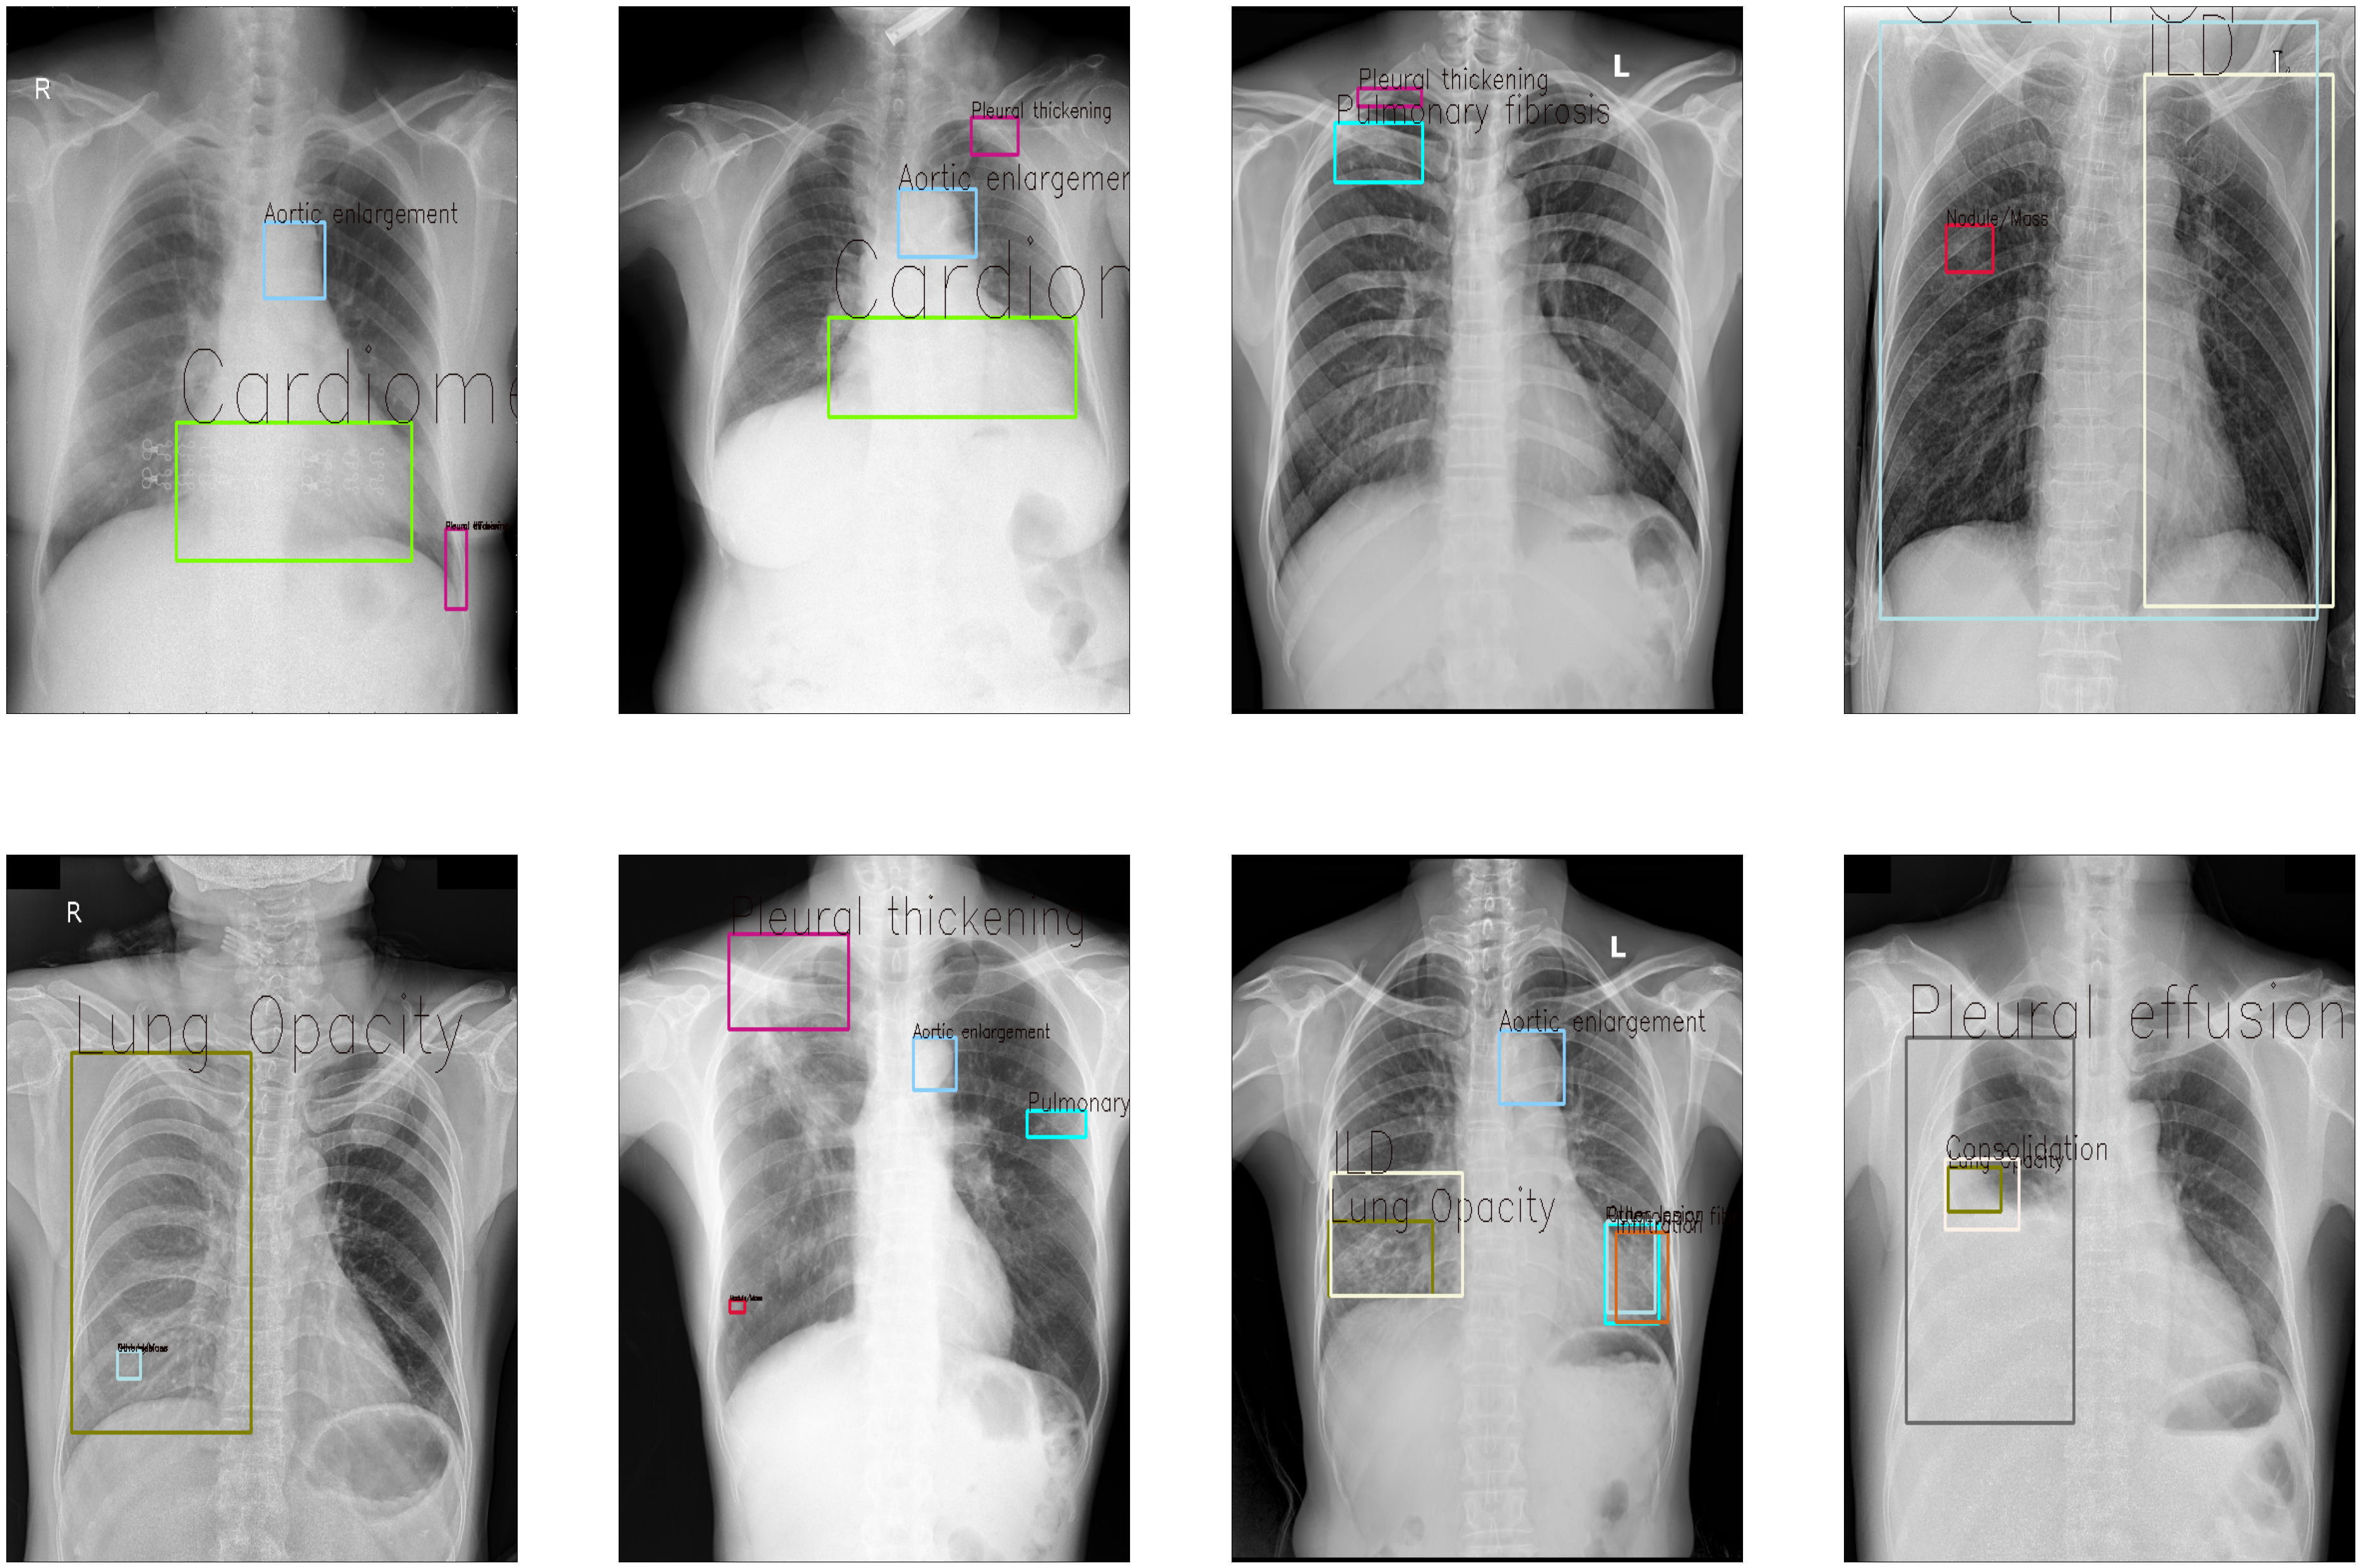

In [ ]:
f, ax= plt.subplots(2, 4, figsize=(48, 32))
for i in range(8):
    ax[i//4][i%4].imshow(show_bb(i), aspect='auto')
    ax[i//4][i%4].set_xticks([]); ax[i//4][i%4].set_yticks([])
plt.show()

### Define folds

In [ ]:
def define_folds(train_df):
    unique_images = train_df["image_id"].unique()
    df_split = pd.DataFrame(unique_images, columns = ['unique_images'])

    # create one column with the number of fold (for the k-fold cross validation)
    df_split["kfold"] = -1
    df_split = df_split.sample(frac=1).reset_index(drop=True)
    y = df_split.unique_images.values
    kf = model_selection.GroupKFold(n_splits=5)
    for f, (t_, v_) in enumerate(kf.split(X=df_split, y=y, groups=df_split.unique_images.values)):
        df_split.loc[v_, "kfold"] = f

    # annotated boxes from same "image id" (image) should be in the same fold [during training each image with its boxes is as one input]
    train_df["kfold"] = -1
    for ind in train_df.index:
         train_df["kfold"][ind] = df_split.loc[ df_split["unique_images"] ==  train_df["image_id"][ind]]["kfold"]

    # train_df.set_index('image_id', inplace=True)
    return train_df

In [ ]:
train_df = define_folds(train_df)

In [ ]:
train_df.head(10)

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   
5  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
6  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
7  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   
8  d3637a1935a905b3c326af31389cb846  Aortic enlargement         0    R10   
9  afb6230703512afc370f236e8fe98806  Pulmonary fibrosis        13     R9   

        x_min       y_min       x_max       y_max  width  height  kfold  
0    0.000000    0.000000    1.000000    1.000000   2332    2580      3  
1    0.000000    0.000000    1.000000    1.000000   2954    3159      4  
2  170.092308  301.369863  406.892308  401.315068   2080    2336      3  
3  280.888889  132.088889  358.000000  181.155556   2304    2880      1  
4    0.000000    0.000000    1.000000    1.000000   2540    3072      0  
5  126.387402   59.500000  190.891339   72.166667   2540    3072      3  
6  301.822319   49.095890  490.265208  434.648924   2285    2555      0  
7  111.052960  359.148225  134.579439  379.304503   2568    3353      4  
8  295.333333  132.088889  338.000000  170.311111   2304    2880      0  
9  374.324409  267.833333  428.548031  339.333333   2540    3072      0

### WBF


In [ ]:
# ensembling
!pip install ensemble_boxes
from tqdm import tqdm
from ensemble_boxes import *

In [ ]:
def boxes_fusion(df):
    # apply weighted boxes fusion for ensemling overlapping annotated boxes
    # Default WBF config
    iou_thr = 0.75
    skip_box_thr = 0.0001
    sigma = 0.1
    results = []
    image_ids = df.index.unique()

    for image_id in tqdm(image_ids, total=len(image_ids)):
        # All annotations for the current image.
        data = df[df.index == image_id]
        kfold = data['kfold'].unique()[0]
        data = data.reset_index(drop=True)

        # WBF expects the coordinates in 0-1 range.
        max_value = data.iloc[:, 4:].values.max()
        data.loc[:, ["x_min", "y_min", "x_max", "y_max"]] = data.iloc[:, 4:] / max_value
        #print("data",data)
        if data.class_id.unique()[0] !=14:
            annotations = {}
            weights = []
            # Loop through all of the annotations
            for idx, row in data.iterrows():
                rad_id = row["rad_id"]
                if rad_id not in annotations:
                    annotations[rad_id] = {
                        "boxes_list": [],
                        "scores_list": [],
                        "labels_list": [],
                    }
                    # We consider all of the radiologists as equal.
                    weights.append(1.0)
                annotations[rad_id]["boxes_list"].append([row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
                annotations[rad_id]["scores_list"].append(1.0)
                annotations[rad_id]["labels_list"].append(row["class_id"])

            boxes_list = []
            scores_list = []
            labels_list = []

            for annotator in annotations.keys():
                boxes_list.append(annotations[annotator]["boxes_list"])
                scores_list.append(annotations[annotator]["scores_list"])
                labels_list.append(annotations[annotator]["labels_list"])

            # Calculate WBF
            boxes, scores, labels = weighted_boxes_fusion(boxes_list,
                scores_list,
                labels_list,
                weights=weights,
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr
            )
            for idx, box in enumerate(boxes):
                results.append({
                    "image_id": image_id,
                    "class_id": int(labels[idx]),
                    "rad_id": "wbf",
                    "x_min": box[0]* max_value,
                    "y_min": box[1]* max_value,
                    "x_max": box[2]* max_value,
                    "y_max": box[3]* max_value,
                    "kfold":kfold,
                })
        # if class is nothing then have it once (instead of 3 times in the same image)
        if data.class_id.unique()[0] ==14:
            for idx, box in enumerate([0]):
                results.append({
                    "image_id": image_id,
                    "class_id": data.class_id[0],
                    "rad_id": "wbf",
                    "x_min": 0,
                    "y_min": 0,
                    "x_max": 1,
                    "y_max": 1,
                    "kfold":kfold,
                })

    results = pd.DataFrame(results)
    return results

In [ ]:
train_df = boxes_fusion(train_df)

100%|██████████| 67914/67914 [02:59<00:00, 377.85it/s]


In [ ]:
train_df.head(10)

# Model + Result

## YOLOv8

Link trên kaggle: https://www.kaggle.com/code/duchai275/yolov8-main/notebook

## DETR

### Preprocessing

In [ ]:
# clone github repo of detr
!git clone https://github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm
import re
import pydicom
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from PIL import Image

# torch.
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection

# CV
import cv2

# DETR FUCNTIONS FOR LOSS
import sys
sys.path.append('./detr/')

# from detr.models.matcher import HungarianMatcher
# from detr.models.detr import SetCriterion

# albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

# Glob
from glob import glob

# mAP
!pip install map_boxes
from map_boxes import mean_average_precision_for_boxes

In [ ]:
n_folds = 5
seed = 42
num_classes = 15
num_queries = 2
null_class_coef = 0.2
BATCH_SIZE = 16
EPOCHS = 12
LR = 2e-5

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
seed_everything(seed)

In [ ]:
def pascal_to_coco(train_df):
    # Good exlanation of coco, pascal etc
    # https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    train_df['coco_x'] = train_df['x_min']
    train_df['coco_y'] = train_df['y_min']
    train_df['coco_w'] = train_df['x_max'] - train_df['x_min']
    train_df['coco_h'] = train_df['y_max'] - train_df['y_min']

    train_df.loc[train_df['class_id'] == 14, 'coco_x'] = 1
    train_df.loc[train_df['class_id'] == 14, 'coco_y'] = 1
    train_df.loc[train_df['class_id'] == 14, 'coco_w'] = 0.5
    train_df.loc[train_df['class_id'] == 14, 'coco_h'] = 0.5

    return train_df

In [ ]:
train_df = pascal_to_coco(train_df)

In [ ]:
def get_train_transforms():
    # image augmentations for the training set
    return A.Compose([A.ToGray(p=0.01),
                      A.Cutout(num_holes=10, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
                      ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    # image augmentations for the validation set
    return A.Compose([ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

### Convert into COCO format

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.1 MB/s eta 0:00:00


In [ ]:
train_df.set_index('image_id', inplace=True)

In [ ]:
DIR_TRAIN_PNG = 'data/vinbigdata/train'

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

class VinDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df.loc[image_id]
        labels = records['class_id']

        image = cv2.imread(f'{DIR_TRAIN_PNG}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        # DETR takes in data in coco format
        boxes = records[['coco_x', 'coco_y', 'coco_w', 'coco_h']].values

        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.array(labels)

        if boxes.ndim == 1 :
            boxes = np.expand_dims(boxes, axis=0)
            labels = np.expand_dims(labels, axis=0)

        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.array(labels)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }

        sample = self.transforms(**sample)
        image = sample['image']
        boxes = sample['bboxes']
        labels = sample['labels']

        # Normalizing BBOXES
        _,h,w = image.shape
        boxes = A.core.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
#  albumentations.core.bbox_utils.normalize_bbox
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])

        return image/255, target, image_id

### Model

In [ ]:
import torch.nn.functional as F
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = True


        self.in_features = self.model.class_embed.in_features

        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes+1)
        self.model.num_queries = self.num_queries

    def forward(self,images):
        return self.model(images)

### Train

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))

    check_repeats = []
    for step, (images, targets, image_ids) in enumerate(tk0):
            if image_ids in check_repeats:
                continue
            else:
                check_repeats.append(image_ids)

                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                #print("images : {}".format(images))

                output = model(images)

                loss_dict = criterion(output, targets)
                weight_dict = criterion.weight_dict

                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

                optimizer.zero_grad()

                losses.backward()
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

                summary_loss.update(losses.item(),BATCH_SIZE)
                tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss

In [ ]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    map_df = pd.DataFrame()
    map_df_target = pd.DataFrame()

    with torch.no_grad():
        check_repeats_val = []
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            if image_ids in check_repeats_val:
                continue
            else:
                check_repeats_val.append(image_ids)

                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                outputs = model(images)

                # MAP targets
                for count, label in enumerate(targets[0]['labels']):
                    text = f'{CLASSES[label]}'
                    x_min = targets[0]['boxes'][count][0] - (targets[0]['boxes'][count][2])/2
                    x_max = targets[0]['boxes'][count][0] + (targets[0]['boxes'][count][2])/2
                    y_min = targets[0]['boxes'][count][1] - (targets[0]['boxes'][count][3])/2
                    y_max = targets[0]['boxes'][count][1] + (targets[0]['boxes'][count][3])/2

                    data = pd.DataFrame({"ImageID": [image_ids[0]],"LabelName": [text],
                    "XMin": [x_min.item()], "XMax": [x_max.item()], "YMin": [y_min.item()], "YMax": [y_max.item()]})
                    map_df_target = map_df_target.append(data)


                probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
                keep = probas.max(-1).values > 0.08
                boxes = rescale_bboxes(outputs['pred_boxes'][0, keep], (512,512))
                prob = probas[keep]

                colors = COLORS * 100
                for p, (x_min, y_min, x_max, y_max), c in zip(prob, boxes.tolist(), colors):

                    cl = p.argmax()
                    text = f'{CLASSES[cl]}'

                    # Dataframe for MAP
                    data = pd.DataFrame({"ImageID": [image_ids[0]],"LabelName": [text], "Conf": [p[cl].item()], "XMin": [x_min/512], "XMax": [x_max/512], "YMin": [y_min/512], "YMax": [y_max/512]})
                    map_df = map_df.append(data)

                loss_dict = criterion(outputs, targets)
                weight_dict = criterion.weight_dict

                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

                summary_loss.update(losses.item(),BATCH_SIZE)
                tk0.set_postfix(loss=summary_loss.avg)

        ann = map_df_target[['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']].values
        det = map_df[['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax']].values
        mean_ap, average_precisions = mean_average_precision_for_boxes(ann, det, iou_threshold=0.4)

        print("mean_ap : {}".format(mean_ap))
        print("average_precisions : {}".format(average_precisions))

    return summary_loss, mean_ap

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def run(train_df, fold):

    df_train = train_df[train_df['kfold'] != fold]
    df_valid = train_df[train_df['kfold'] == fold]

    train_dataset = VinDataset(
    image_ids=df_train.index.values,
    dataframe=df_train,
    transforms=get_train_transforms()
    )

    valid_dataset = VinDataset(
    image_ids=df_valid.index.values,
    dataframe=df_valid,
    transforms=get_valid_transforms()
    )

    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    # Bipartite Matching Loss
    matcher = HungarianMatcher()
    weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
    losses = ['labels', 'boxes', 'cardinality']

    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)

    LR = 3e-5
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    best_loss = 0
    val_loss_track_switch = 0
    all_train_losses = []
    all_valid_losses = []
    all_mean_ap = []
    columns = ['train_losses', 'valid_losses', 'mean_ap']
    df_losses = pd.DataFrame(columns = columns )
    df_losses.to_csv("all_losses.csv",mode='a', index=False)
    for epoch in range(EPOCHS):
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        if val_loss_track_switch % 2 == 0:
            LR = LR/1.12
            valid_loss, map_validation = eval_fn(valid_data_loader, model,criterion, device)
        val_loss_track_switch = val_loss_track_switch + 1

        df_losses = df_losses.append({'train_losses': train_loss.avg,'valid_losses': valid_loss.avg,'mean_ap': map_validation}, ignore_index=True)
        df_losses.to_csv("all_losses.csv",index=False, header=False,mode='a')
        df_losses.drop(df_losses.tail(1).index,inplace=True)

        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

        if map_validation > best_loss:
            best_loss = map_validation
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'detr_model.pth')
    return model

In [ ]:
# train_df = preprocessing()
# def model_training():
    # train_df = preprocessing()
import torch, gc
gc.collect()
torch.cuda.empty_cache()
run(train_df, fold=0)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
100%|██████████| 13722/13722 [03:56<00:00, 58.01it/s, loss=0.718] 


Number of files in annotations: 3000
Number of files in predictions: 3000
Unique classes: 15
Detections length: 3000
Annotations length: 3000
Aortic enlargement             | 0.221730 |    1456
Atelectasis                    | 0.000000 |      52
Calcification                  | 0.000000 |     177
Cardiomegaly                   | 0.214916 |    1108
Consolidation                  | 0.000000 |     118
ILD                            | 0.019737 |     209
Infiltration                   | 0.028282 |     277
Lung Opacity                   | 0.037196 |     538
No Finding                     | 0.078721 |    6297
Nodule/Mass                    | 0.003232 |     586
Other lesion                   | 0.001208 |     416
Pleural effusion               | 0.068298 |     510
Pleural thickening             | 0.031814 |     951
Pneumothorax                   | 0.000000 |      41
Pulmonary fibrosis             | 0.034541 |     986
mAP: 0.049312
mean_ap : 0.04931170171215536
average_precisions : {'Aortic enla

100%|██████████| 3387/3387 [19:14<00:00,  2.93it/s, loss=1.06]


|EPOCH 2| TRAIN_LOSS 1.063196520476979| VALID_LOSS 0.7181824239393075|


100%|██████████| 13722/13722 [03:44<00:00, 61.14it/s, loss=0.435] 


Number of files in annotations: 3000
Number of files in predictions: 3000
Unique classes: 15
Detections length: 3000
Annotations length: 3000
Aortic enlargement             | 0.336605 |    1456
Atelectasis                    | 0.031602 |      52
Calcification                  | 0.010902 |     177
Cardiomegaly                   | 0.424396 |    1108
Consolidation                  | 0.050543 |     118
ILD                            | 0.048615 |     209
Infiltration                   | 0.073666 |     277
Lung Opacity                   | 0.065525 |     538
No Finding                     | 0.108866 |    6297
Nodule/Mass                    | 0.023166 |     586
Other lesion                   | 0.009606 |     416
Pleural effusion               | 0.130959 |     510
Pleural thickening             | 0.089996 |     951
Pneumothorax                   | 0.000000 |      41
Pulmonary fibrosis             | 0.090222 |     986
mAP: 0.099645
mean_ap : 0.09964457016648537
average_precisions : {'Aortic enla

100%|██████████| 3387/3387 [19:18<00:00,  2.92it/s, loss=0.885]


|EPOCH 4| TRAIN_LOSS 0.8850440370110871| VALID_LOSS 0.43513213301201664|


100%|██████████| 13722/13722 [03:36<00:00, 63.45it/s, loss=0.45] 


Number of files in annotations: 3000
Number of files in predictions: 3000
Unique classes: 15
Detections length: 3000
Annotations length: 3000
Aortic enlargement             | 0.336317 |    1456
Atelectasis                    | 0.037976 |      52
Calcification                  | 0.017265 |     177
Cardiomegaly                   | 0.425351 |    1108
Consolidation                  | 0.078062 |     118
ILD                            | 0.064730 |     209
Infiltration                   | 0.119766 |     277
Lung Opacity                   | 0.105128 |     538
No Finding                     | 0.109437 |    6297
Nodule/Mass                    | 0.024204 |     586
Other lesion                   | 0.017054 |     416
Pleural effusion               | 0.183200 |     510
Pleural thickening             | 0.098789 |     951
Pneumothorax                   | 0.019302 |      41
Pulmonary fibrosis             | 0.110853 |     986
mAP: 0.116496
mean_ap : 0.11649559547503686
average_precisions : {'Aortic enla

100%|██████████| 3387/3387 [19:14<00:00,  2.93it/s, loss=0.746]


|EPOCH 6| TRAIN_LOSS 0.746433557729683| VALID_LOSS 0.45007564416527746|


100%|██████████| 13722/13722 [03:31<00:00, 64.88it/s, loss=0.387] 


Number of files in annotations: 3000
Number of files in predictions: 3000
Unique classes: 15
Detections length: 3000
Annotations length: 3000
Aortic enlargement             | 0.413413 |    1456
Atelectasis                    | 0.052169 |      52
Calcification                  | 0.039902 |     177
Cardiomegaly                   | 0.460689 |    1108
Consolidation                  | 0.089143 |     118
ILD                            | 0.051856 |     209
Infiltration                   | 0.122911 |     277
Lung Opacity                   | 0.143534 |     538
No Finding                     | 0.109360 |    6297
Nodule/Mass                    | 0.036522 |     586
Other lesion                   | 0.016281 |     416
Pleural effusion               | 0.224021 |     510
Pleural thickening             | 0.105193 |     951
Pneumothorax                   | 0.021360 |      41
Pulmonary fibrosis             | 0.115958 |     986
mAP: 0.133488
mean_ap : 0.13348761301327197
average_precisions : {'Aortic enla

100%|██████████| 3387/3387 [19:16<00:00,  2.93it/s, loss=0.625]


|EPOCH 8| TRAIN_LOSS 0.6250046106445286| VALID_LOSS 0.3874448461184899|


100%|██████████| 13722/13722 [03:24<00:00, 67.17it/s, loss=0.419] 


Number of files in annotations: 3000
Number of files in predictions: 3000
Unique classes: 15
Detections length: 3000
Annotations length: 3000
Aortic enlargement             | 0.436574 |    1456
Atelectasis                    | 0.033134 |      52
Calcification                  | 0.030416 |     177
Cardiomegaly                   | 0.432638 |    1108
Consolidation                  | 0.078143 |     118
ILD                            | 0.060145 |     209
Infiltration                   | 0.124056 |     277
Lung Opacity                   | 0.133093 |     538
No Finding                     | 0.111816 |    6297
Nodule/Mass                    | 0.056747 |     586
Other lesion                   | 0.020181 |     416
Pleural effusion               | 0.233835 |     510
Pleural thickening             | 0.105483 |     951
Pneumothorax                   | 0.103678 |      41
Pulmonary fibrosis             | 0.126569 |     986
mAP: 0.139100
mean_ap : 0.1391004567278632
average_precisions : {'Aortic enlar

100%|██████████| 3387/3387 [19:21<00:00,  2.92it/s, loss=0.546]


|EPOCH 10| TRAIN_LOSS 0.5463140606352246| VALID_LOSS 0.4185522423287233|


100%|██████████| 13722/13722 [03:14<00:00, 70.41it/s, loss=0.426] 


Number of files in annotations: 3000
Number of files in predictions: 3000
Unique classes: 15
Detections length: 3000
Annotations length: 3000
Aortic enlargement             | 0.430285 |    1456
Atelectasis                    | 0.050301 |      52
Calcification                  | 0.029440 |     177
Cardiomegaly                   | 0.463597 |    1108
Consolidation                  | 0.064144 |     118
ILD                            | 0.060069 |     209
Infiltration                   | 0.125843 |     277
Lung Opacity                   | 0.129376 |     538
No Finding                     | 0.123421 |    6297
Nodule/Mass                    | 0.070017 |     586
Other lesion                   | 0.019997 |     416
Pleural effusion               | 0.253241 |     510
Pleural thickening             | 0.122154 |     951
Pneumothorax                   | 0.026296 |      41
Pulmonary fibrosis             | 0.129557 |     986
mAP: 0.139849
mean_ap : 0.13984925064839146
average_precisions : {'Aortic enla

100%|██████████| 3387/3387 [19:17<00:00,  2.93it/s, loss=0.47]

|EPOCH 12| TRAIN_LOSS 0.4696923401113242| VALID_LOSS 0.4257970343902707|


DETRModel(
  (model): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
           

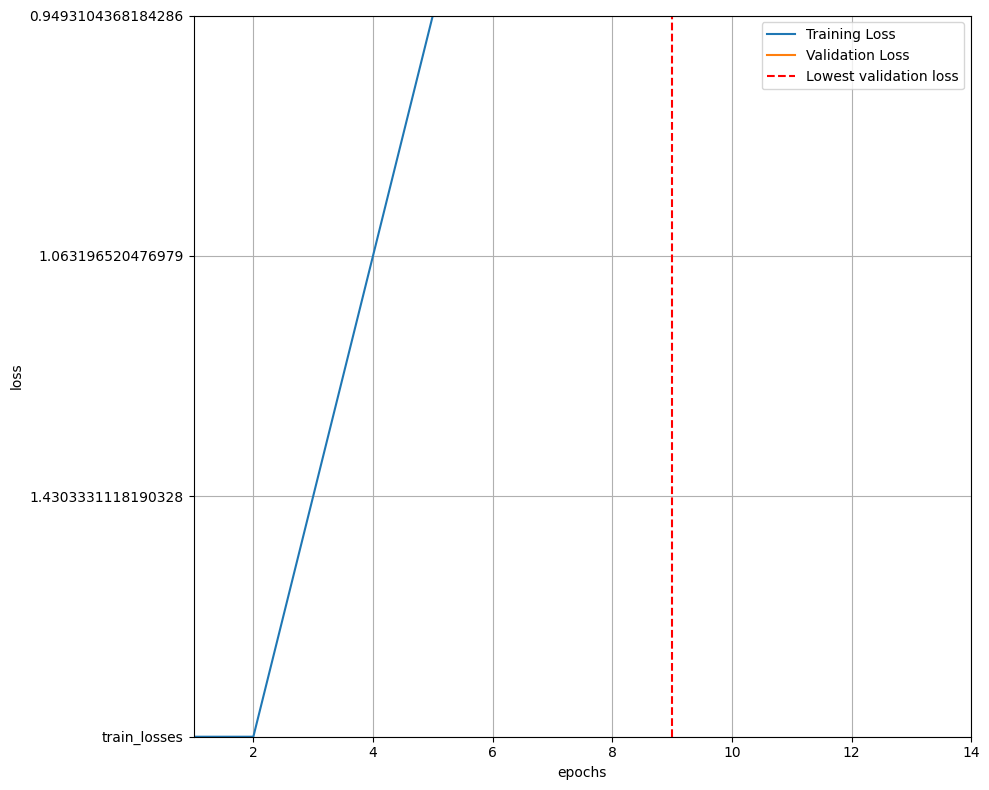

In [ ]:
loss = pd.read_csv('all_losses.csv')
train_loss = loss['train_losses'].tolist()
valid_loss = loss['valid_losses'].tolist()
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Lowest validation loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 3) # consistent scale
plt.xlim(1, len(train_loss)) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

### Inference

In [ ]:
def load_model():
    ## Loading a model
    num_classes = 15
    num_queries = 2
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model.load_state_dict(torch.load("./detr_model.pth", map_location=torch.device('cpu')))
    return model

In [ ]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
CLASSES = [
    'Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation',
    'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion',
    'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis', 'No Finding'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
def view_sample_check_MAP(df_valid,model,device, index_to_show):
    map_df = pd.DataFrame()
    map_df_target = pd.DataFrame()

    valid_dataset = VinDataset(
    image_ids=df_valid.index.values,
    dataframe=df_valid,
    transforms=get_valid_transforms()
    )

    valid_data_loader = DataLoader(valid_dataset,
                                   batch_size=164,
                                   shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)

    images, targets, image_ids = next(iter(valid_data_loader))
    #print("targets[index_to_show] : {}".format(targets[index_to_show]))
    _,h,w = images[index_to_show].shape # for de normalizing images
    print("h,w  : {}".format(h,w))
    print("targets[index_to_show]['labels']  : {}".format(targets[index_to_show]['labels']))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    annotated_boxes = targets[index_to_show]['boxes'].cpu().numpy()
    print("Anottated boxes.shape AFTER picking ""index_to_show .shape""  : {}".format(annotated_boxes.shape))
    print("Anottated boxes[0] AFTER picking ""index_to_show""  : {}".format(annotated_boxes[0]))
    annotated_boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(annotated_boxes,h,w)]
    print("denormalize_bboxes Anottated boxes[0] AFTER picking ""index_to_show"" (in coco) : {}".format(annotated_boxes[0]))
    #annotated_boxes = rescale_bboxes(annotated_boxes[index_to_show], (512,512))

    # MAP targets
    for count, label in enumerate(targets[index_to_show]['labels']):
        print("label : {}".format(label))
        text = f'{CLASSES[label]}'
        print("text : {}".format(text))
        x_min = targets[index_to_show]['boxes'][count][0] - (targets[index_to_show]['boxes'][count][2])/2
        x_max = targets[index_to_show]['boxes'][count][0] + (targets[index_to_show]['boxes'][count][2])/2
        y_min = targets[index_to_show]['boxes'][count][1] - (targets[index_to_show]['boxes'][count][3])/2
        y_max = targets[index_to_show]['boxes'][count][1] + (targets[index_to_show]['boxes'][count][3])/2

        data = pd.DataFrame({"ImageID": [image_ids[0]],"LabelName": [text],
        "XMin": [x_min.item()], "XMax": [x_max.item()], "YMin": [y_min.item()], "YMax": [y_max.item()]})
        map_df_target = map_df_target.append(data)

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images)

    # keep only predictions with 0.7+ confidence
    print("outputs['pred_logits'].shape : {}".format(outputs['pred_logits'].shape))
    print("outputs['pred_logits'].softmax(-1).shape : {}".format(outputs['pred_logits'].softmax(-1).shape))
    print("outputs['pred_logits'].softmax(-1)[0, :, :-1].shape : {}".format(outputs['pred_logits'].softmax(-1)[0, :, :-1].shape))
    probas = outputs['pred_logits'].softmax(-1)[index_to_show, :, :-1]
    print("probas.shape : {}".format(probas.shape))
    keep = probas.max(-1).values > 0.08
    print("keep : {}".format(keep))
    # convert boxes from [0; 1] to image scales

    print("outputs['pred_boxes'].shape : {}".format(outputs['pred_boxes'].shape))
    #print("outputs['pred_boxes'][index_to_show]: {}".format(outputs['pred_boxes'][index_to_show]))

    boxes = rescale_bboxes(outputs['pred_boxes'][index_to_show, keep], (512,512))
    print("Predicted boxes.shape AFTER picking ""index_to_show""  : {}".format(boxes.shape))
    #print("Predicted boxes[0] AFTER picking ""index_to_show"" (in pascal) : {}".format(boxes[0]))
    prob = probas[keep]
    #return probas[keep],bboxes_scaled,image_ids

    string_from_image = f"../input/vinbigdata-512-image-dataset/vinbigdata/train/{image_ids[index_to_show]}.png"

    im = Image.open(string_from_image)
    pil_img = im.convert('RGB')
    pil_img.save('colors.jpg')
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    #print("prob : {}".format(prob))
    for p, (x_min, y_min, x_max, y_max), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=c, linewidth=3))
        print("xmin : {}".format(xmin))
        print("ymin : {}".format(ymin))
        print("xmax : {}".format(xmax))
        print("ymax : {}".format(ymax))

        cl = p.argmax()
        print("cl : {}".format(cl))
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        text_df = f'{CLASSES[cl]}'

        # Dataframe for MAP
        data = pd.DataFrame({"ImageID": [image_ids[0]],"LabelName": [text_df], "Conf": [p[cl].item()], "XMin": [xmin/512], "XMax": [xmax/512], "YMin": [ymin/512], "YMax": [ymax/512]})
        map_df = map_df.append(data)
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Plot the onces annotated by the doctors
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    #print("prob : {}".format(prob))
    for p, (x0, x1, x2, x3), c in zip(targets[index_to_show]['labels'], annotated_boxes, colors):
        ax.add_patch(plt.Rectangle((x0-x2/2, x1-x3/2), x2, x3,
                                   fill=False, color=c, linewidth=3))
        #print("x0 : {}".format(x0))
        #print("x1 : {}".format(x1))
        #print("x2 : {}".format(x2))
        #print("x3 : {}".format(x3))
        #print("annotated_boxes : {}".format(annotated_boxes))
        cl = p
        print("cl : {}".format(cl))
        text = f'{CLASSES[cl]}'
        ax.text(x0, x1, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

    print("map_df_target : {}".format(map_df_target))
    print("map_df : {}".format(map_df))

    ann = map_df_target[['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']].values
    det = map_df[['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax']].values
    mean_ap, average_precisions = mean_average_precision_for_boxes(ann, det)
    print(f"recall: {0.2520}")
    print(f"precision: {0.2358}")
    print(f"f1: {0.2432}")

    print("mean_ap : {}".format(mean_ap))
    print("average_precisions : {}".format(average_precisions))

    return

In [ ]:
def visualize_results():
    train_df = preprocessing()
    model = load_model()
    view_sample_check_MAP(train_df[train_df['kfold'] == 0],model=model,device=torch.device('cpu'),index_to_show=10)
    return
# uncomment if you want to visualize the training results
visualize_results()